# BNN

Bayesian neural networks are in the family of probabilistic neural networks. Instead of learning deterministic weight for the hidden layers, they learn a distribution of probability of those weights. 

"Bayesian inference allows us to learn a probability distribution over possible neural networks."

One could ask what's the utility of such neural networks, and the main answers are :  

 * to reduce overfitting,
 * allow learning on small dataset 
 * give a grasp of the uncertainity of the predictions.

In BNN weights **not** are hard values :

\begin{align}
  y &= f(W^Tx) \\
    &= f(w_1x_1 + w_2x_2 + \cdots + w_n x_n)\\\\
    & w_n \sim \mathcal{N}(\mu_n, \sigma_n),\: \forall n \in \mathbb{N}
\end{align}


therefor the optimization problem is different from classical NN, we want to learn $ \{\mu_n,\: \sigma_n\} $


### In a Standard NN 

* Training 

we want to maximise the log likelihood of our training data :

\begin{align}
  \theta^* &= \arg\,max_{\theta} \;\; \Sigma_{(x_i, y_i) \in \mathcal{D_{tr}}} \; log[p(y_i|x_i, \mathcal{D_{tr}})]  
\end{align}

In practice it means minimizing our loss function

\begin{align}
  \theta^* &=  \Sigma_{(x_i, y_i) \in \mathcal{D_{tr}}} \; \mathcal{L}(F_\theta(x_i), y_i)
\end{align}

* Prediction 

test likelihood : $p(\hat{y}| \hat{x}, \theta^*) $

in practice forward pass in our trained network : $\hat{y} = F_{\theta^*}(\hat{x}) $

### In Bayesian Neural Network 

* Training 

As no hard values for $\theta$ we want to learn **the parameters of the distribution** that $\theta$ will be sampled from :

lets consider the weight distribution as a multivariate gaussian 

\begin{align}
  \mu^*, \Sigma^* = \Sigma_{(x_i, y_i) \in \mathcal{D_{tr}}} \; log[p(y_i|x_i, \mathcal{D_{tr}})] - KL[p(\theta), p(\theta_0)] 
\end{align}

Here KL acts as a regularisation terme to prevent too big sampled weights values and hence prevents overfitting. 

$\theta \sim \mathcal{N}(\mu, \Sigma) \\
 \theta_0 \sim \mathcal{N}(0, I)$

In practice : 

\begin{align}
  \mu^*, \Sigma^* = arg\,min_{\mu, \Sigma} \;\; \Sigma_{(x_i, y_i) \in \mathcal{D_{tr}}} \; \mathcal{L}(F_{\theta}(x_i, y_i)) + KL[p(\theta), p(\theta_0)] 
\end{align} 

* Prediction 

\begin{align} 
  & p(\hat{y} | \hat{x}, \mathcal{D_{tr}}) = \int p(\hat{y} | \hat{x}, \theta^*)p(\theta^* | \mathcal{D_{tr}})d\theta^* \\
  & \theta^* \sim \mathcal{N}(\mu^*, \Sigma^*)
\end{align}

i.e the expectation of the test likelihood wrt to the posterior distribution

In practice  : 

$\hat{y} = \frac{1}{K} \Sigma_{k=1}^K F_{\theta_k^*}(\hat{x})$

$\theta_k^* \sim \mathcal{N}(\mu^*, \Sigma^*)$




source : https://www.youtube.com/watch?v=OVne8jDKGUI

Bayesian statistics is a common statistical
modelling paradigm which involves the fusion of prior knowledge about the unknown quantity to
be inferred with observed data. The result is a posterior measure over the unknown quantity.

https://people.inf.elte.hu/kiss/11dwhdm/roc.pdf

# 1. Imports, Utilities and Data preprocessing 

## 1.1 Imports

In [1]:
%pip install --user -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import sklearn.metrics

from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, precision_recall_fscore_support,f1_score, accuracy_score, roc_curve, classification_report, auc, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import AUC, Accuracy 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, InputLayer, BatchNormalization, LeakyReLU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
import keras_tuner as kt

import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings("ignore")


## 1.2 Load and transform the Dataset 

In [34]:
SEED = 42
df = pd.read_excel("cleanDS.xlsx", engine='openpyxl')
df.drop(['Unnamed: 0'], axis=1, inplace = True)
df.head()

,Date,Espece,Direct,Culture,Prelevement,Service,BMR_ATCD,Periode,Amoxicilline,Augmentin,...,Ceftazidime + Ciprofloxacine,Cefepime + Ciprofloxacine,Aztreonam + Ciprofloxacine,Imipenem + Ciprofloxacine,Meropenem + Ciprofloxacine,Tazocilline + Vancomycine,Cefepime + Vancomycine,Meropenem + Vancomycine,Cefotaxime - Ceftriaxone + Metronidazole,Cefepime + Metronidazole
0,0.112285,157.0,0.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.112285,157.0,0.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.799296,253.0,4.0,8.0,0.0,3.0,-1.0,2.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.800078,253.0,4.0,8.0,0.0,0.0,-1.0,2.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.800078,253.0,4.0,8.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:
antibiotiques = df.columns[8:]
n_antibiotiques = len(antibiotiques)

In [4]:
# Save period D, 2020 period Covid for validation
df_D = df[df.Periode == 3]
df_E = df[df.Periode == 4]
df_F = df[df.Periode == 5]
df_G = df[df.Periode == 6]
df_H = df[df.Periode == 7]
df   = df[df.Periode <3]

In [5]:
# Get the columns in each stage
#def getXY (dataframe, Stade): 
    X = pd.DataFrame()
    y = pd.DataFrame()
    
    if Stade == 0 :
            X = dataframe[['Date','BMR_ATCD','Service']]
            X[['Prelevement','Direct','Culture','Espece']] = -1
     
    elif Stade == 1 :
            X = dataframe[['Date','BMR_ATCD','Service','Prelevement']]
            X[['Direct','Culture','Espece']] = -1

    elif Stade == 2 :
            X = dataframe[['Date','BMR_ATCD','Service','Prelevement','Direct']]
            X[['Culture','Espece']] = -1

    elif Stade == 3 :
            X = dataframe[['Date','BMR_ATCD','Service','Prelevement','Culture']] 
            X[['Direct','Espece']] = -1
    
    elif Stade == 4 :
             X = dataframe[['Date','BMR_ATCD','Service','Prelevement','Culture','Espece']] 
             X[['Direct']] = -1
    else: 
             raise ValueError('Stade not in [1,2,3,4]')
        

    antibiotiques = dataframe.columns[8:]
    y = dataframe.loc[:,antibiotiques]

    return (X,y)

def createDataSet(dataframe) :
  stades = [1,2,3]
  X, y =  getXY (dataframe, 4) 
  for stade in stades: 
    X2,y2 =  getXY(dataframe, stade) 
    X = X.append(X2)
    y = y.append(y2)

  return (X,y)

IndentationError: unexpected indent (Temp/ipykernel_14580/21708014.py, line 3)

In [6]:
# Version 2
def getXY(dataframe, stade): 
    X = pd.DataFrame()
    y = pd.DataFrame()
    
    if stade == 0 :
            X = dataframe[['Date','BMR_ATCD','Service']]
            X[['Prelevement','Direct','Culture','Espece']] = -1
     
    elif stade == 1 :
            X = dataframe[['Date','BMR_ATCD','Service','Prelevement']]
            X[['Direct','Culture','Espece']] = -1

    elif stade == 2 :
            X = dataframe[['Date','BMR_ATCD','Service','Prelevement','Direct']]
            X[['Culture','Espece']] = -1

    elif stade == 3 :
            X = dataframe[['Date','BMR_ATCD','Service','Prelevement','Direct','Culture']] 
            X[['Espece']] = -1
    
    elif stade == 4 :
             X = dataframe[['Date','BMR_ATCD','Service','Prelevement','Direct','Culture','Espece']] 
    else: 
             raise ValueError('Stade not in [1,2,3,4]')
        

    antibiotiques = dataframe.columns[8:]
    y = dataframe.loc[:,antibiotiques]

    return (X,y)

def createDataSet(dataframe) :
  stades = [1,2,3]
  X, y =  getXY(dataframe, 4) 
  for stade in stades: 
    X2,y2 =  getXY(dataframe, stade) 
    X = X.append(X2)
    y = y.append(y2)

  return (X,y)

## 1.3 Train test val split



In [38]:
X, y = createDataSet(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_val, y_val = createDataSet(df_D)

In [8]:
"""
fig = plt.figure(figsize=(15, 10))
for i in range(n_antibiotiques):
  plt.bar(y.columns[i], [np.count_nonzero(y.values[:,i])], color='blue', label='sensitive')
  plt.bar(y.columns[i], np.count_nonzero(y.values[:, i] == 0), color='red', label='resistant')
  plt.xticks(rotation='90')
"""

"\nfig = plt.figure(figsize=(15, 10))\nfor i in range(n_antibiotiques):\n  plt.bar(y.columns[i], [np.count_nonzero(y.values[:,i])], color='blue', label='sensitive')\n  plt.bar(y.columns[i], np.count_nonzero(y.values[:, i] == 0), color='red', label='resistant')\n  plt.xticks(rotation='90')\n  \n"

## 1.4 Utility functions

### Evaluations

In [ ]:
def single_input_evaluation(model, nb_iter=10):
  sample = df.sample()
  X_sample = sample[['Date', 'Espece', 'Direct', 'Culture', 'Prelevement', 'Service', 'BMR_ATCD']]
  y_sample = sample[sample.columns[8:]]

  print(X_sample)
  
  predicted = []
  for _ in range(nb_iter):
      predicted.append(model(X_sample.values))
  
  means = np.mean(predicted, axis=0)
  ranges = np.std(predicted, axis=0)
  
  print('mean ranges : ', np.mean(ranges))
  print('median ranges : ', np.median(ranges))
  
  print('precision recall f-score : ', precision_recall_fscore_support(y_sample, means.round(), average='weighted'))

  correct_ranges = []
  incorrect_ranges = []
  for i in range(len(means[0])):
    print('prediction mean : ', means[0][i], '=> ', means[0][i].round(), '\t range : ', 
                                ranges[0][i],'\t actual : ', y_sample.values[0][i],
                                '\t CORRECT ! ' if means[0][i].round() == y_sample.values[0][i] else '\t INCORRECT !',
                                '\t', y_val.columns[i])
    
    if means[0][i].round() == y_sample.values[0][i]:
      correct_ranges.append(ranges[0][i])
    else:  
      incorrect_ranges.append(ranges[0][i])
  
  print('\n')
  print('correct ranges mean : ', np.mean(correct_ranges))
  print('incorrect ranges mean : ', np.mean(incorrect_ranges))

  plt.boxplot(means[0])
  plt.title('box plot of prediction means')

  plt.show()

  return means, ranges

### Others

In [10]:
def train_model(X_train, X_test, y_train, y_test, model, batch_size=32, epochs=200, es=True):
  
  device_name = tf.test.gpu_device_name()
  if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
  else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

  with tf.device(device_name):
    if es:
      earlystopping = callbacks.EarlyStopping(monitor="val_AUC_PR", 
                                          mode="min", patience = 50,
                                          min_delta=0.01, 
                                          verbose = 1, 
                                          restore_best_weights = True)
    else:
      earlystopping = None

    model.fit(X_train, y_train, batch_size=batch_size,  verbose=1, epochs=epochs,
                                validation_data=(X_test, y_test),
                                callbacks=[earlystopping])

  return model

# 2. Baseline Model

Gobal Neural Network with missing values.

> * 4 layer MLP 
> * 300 200 300 200
> * leaky relu activation 
> * lr = 0.0014 
> * batch size = 256 


# Why the probability of a simple mlp does not give us the uncertainty ? 

in a clf problem the softmax/sigmoid output gives you a probability value for each class, but its not the same as uncertainty ! The softmax/sigmoid probability is the probability that an input us a given class relative to the other classes, hence it does not help to explain the model overall confidence. 

# 3. First BNN attempt

[What Uncertainties Do We Need in Bayesian Deep
Learning for Computer Vision?](https://arxiv.org/pdf/1703.04977.pdf)

[bayesian nn classifier](https://github.com/kyle-dorman/bayesian-neural-network-blogpost)


[Hands-on Bayesian Neural Networks - A Tutorial for Deep Learning Users](https://arxiv.org/pdf/2007.06823.pdf)

[choosing \sigma knowing the expected scale of the considered parameters](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

[priors in Bayesian deep learning: a review](https://arxiv.org/pdf/2105.06868.pdf)

[Radial and Directional Posteriors for Bayesian Neural Networks
](https://arxiv.org/pdf/1902.02603.pdf)

[Radial Bayesian Neural Networks: Beyond Discrete Support In
Large-Scale Bayesian Deep Learning](https://arxiv.org/pdf/1907.00865.pdf)

[Weight Uncertainty in Neural Networks](https://arxiv.org/pdf/1505.05424.pdf)

### Priors

In [20]:
# @title Multivariate Gaussian Diag prior
def gaussian_prior(kernel_size, bias_size, dtype=tf.float64): # p(w) ~ N(0, 1)
    n = kernel_size + bias_size
    alpha = 1
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)*alpha
                )
            )
        ]
    )
    return prior_model

In [10]:
def horseshoe_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    scale=1
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.Horseshoe(scale=tf.ones(n))
              )
        ]
    )
    return prior_model

In [33]:
def laplace_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.Laplace(loc=tf.zeros(n), scale=tf.ones(n))
                )
        ]
    )
    return prior_model

In [12]:
def radial_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    scale=1
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: Radial()
            )
        ]
    )
    return prior_model

### Posteriors

In [21]:
# MultivariateNormalTriL : multivariate normal dist on R^k 
# to approximate posterior q_phi(w) ~ p(w | D) 
# variational posterior weight distribution 
def gaussian_posterior(kernel_size, bias_size, dtype=tf.float64): 
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [81]:
def normal_posterior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.IndependentNormal.params_size(n), dtype=dtype
            ),
            tfp.layers.IndependentNormal(n),
        ]
    )
    return posterior_model

## Radial distribution

* random direction : $\epsilon_{\text{MFVI}} \sim \mathcal{N}(0, I)$
* distance : r $\sim \mathcal{N}(0, I)$
* normalize each variational sample independently : direction = $ \frac{\epsilon_{\text{MFVI}}}{\|  \epsilon_{\text{MFVI}}\|}$ (i.e Uniform)

return $\epsilon$-radial = direction * distance

from https://github.com/SebFar/radial_bnn




In [27]:
class Radial(tfd.distribution.AutoCompositeTensorDistribution):
  def __init__(self, loc=0.0, scale=1.0, validate_args=False, allow_nan_stats=False, name='Radial'):
    parameters = dict(locals())

    super(Radial, self).__init__(dtype=tf.float32,
                                 reparameterization_type=tfd.FULLY_REPARAMETERIZED,
                                 validate_args=validate_args,
                                 allow_nan_stats=allow_nan_stats, 
                                 parameters=parameters,
                                 name=name)
    self.loc = loc 
    self.scale = scale 
    self._parameters = parameters
    self.r = tfd.Normal(loc=loc, scale=scale)
    self.dir = tfd.Normal(loc=loc, scale=scale)
  
  def _sample_n(self, n=1, seed=None):
    dir = self.dir.sample(n, seed)
    r = self.r.sample(n, seed)

    return r * dir /tf.norm(dir)

  def _log_prob(self, value):
    log_r = self.r.log_prob(value)
    log_dir = self.dir.log_prob(value)
    u_log_dir = log_dir / tf.norm(log_dir) # log of a norm == norm of log ? 
    return log_r + u_log_dir

  def _parameter_properties(self, num_classes=None):
    return []

radial = Radial()
radial.sample(3)


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.64270085, 0.0301734 , 0.40459388], dtype=float32)>

In [28]:
def radial_posterior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
              shape=(n, 2) # 2 for loc and scale (aka mu & sigma)
            ),
            tfp.layers.DistributionLambda(
                lambda t : Radial(loc=t[..., 0], scale=t[..., 1])
            )
        ]
    )
    
    return posterior_model

In [113]:
t=[[1,2,3],
   [1,2,3],
   [1,2,3]]


print(t[..., 2:])

TypeError: list indices must be integers or slices, not tuple

In [11]:
# Prior is not trainable
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfp.layers.DistributionLambda(
           lambda t: tfd.Laplace(loc = tf.zeros(n), scale= 2 * tf.ones(n))
       )                     
  ])

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale= 1e-5 + 0.003 * tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

### Base bnn

In [12]:
def create_bnn_model(units=100, activation='relu', lr=0.005, 
                     prior=prior,  posterior=posterior): 

  # input layer 
  inputs = keras.Input(shape=(X_train.shape[1],))

  # hidden layers
  x = tfp.layers.DenseVariational(units=20, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation=activation)(inputs)
  
  x = tfp.layers.DenseVariational(units=20, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation=activation)(x)
  
  
  outputs = Dense(units=n_antibiotiques,
                  activation='sigmoid')(x)
  
  """
  outputs = tfp.layers.DenseVariational(units=n_antibiotiques, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='sigmoid')(x)
  """
  
  # model compile
  model = keras.Model(inputs=inputs, outputs=outputs, name='base_BNN')

  opt = keras.optimizers.Adam(learning_rate=lr)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=opt, metrics=['Precision',
                                        'Recall',
                                        AUC(name='AUC_PR', curve='PR', multi_label=True),
                                        AUC(name='AUC_ROC', curve='ROC', multi_label=True),
                                        ])
  model.summary()

  return model

[Exploring the Limits of Epistemic Uncertainty
Quantification in Low-Shot Settings](https://openreview.net/pdf?id=9HNQYYFfROB)

[Calibration: the Achilles heel of predictive analytics](https://bmcmedicine.biomedcentral.com/articles/10.1186/s12916-019-1466-7)

In [13]:
base_bnn = create_bnn_model()
base_bnn = train_model(X_train, X_test, y_train, y_test, base_bnn, epochs=40, es=True)

Model: "base_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_variational (DenseVar  (None, 20)               320       
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 20)               840       
 ariational)                                                     
                                                                 
 dense (Dense)               (None, 47)                987       
                                                                 
Total params: 2,147
Trainable params: 2,147
Non-trainable params: 0
_________________________________________________________________
No GPU, using /device:CPU:0.
Epoch 1/40
2639/2639 [=====

Epoch 28/40
2639/2639 [==============================] - 4s 2ms/step - loss: -2.8699 - precision: 0.8422 - recall: 0.9468 - AUC_PR: 0.8300 - AUC_ROC: 0.7289 - val_loss: -2.9025 - val_precision: 0.8293 - val_recall: 0.9615 - val_AUC_PR: 0.8289 - val_AUC_ROC: 0.7251
Epoch 29/40
2639/2639 [==============================] - 4s 1ms/step - loss: -2.9583 - precision: 0.8415 - recall: 0.9472 - AUC_PR: 0.8287 - AUC_ROC: 0.7265 - val_loss: -2.9945 - val_precision: 0.8374 - val_recall: 0.9505 - val_AUC_PR: 0.8296 - val_AUC_ROC: 0.7327
Epoch 30/40
2639/2639 [==============================] - 4s 2ms/step - loss: -3.0373 - precision: 0.8424 - recall: 0.9458 - AUC_PR: 0.8289 - AUC_ROC: 0.7256 - val_loss: -3.0770 - val_precision: 0.8345 - val_recall: 0.9555 - val_AUC_PR: 0.8317 - val_AUC_ROC: 0.7340
Epoch 31/40
2639/2639 [==============================] - 4s 2ms/step - loss: -3.1187 - precision: 0.8417 - recall: 0.9466 - AUC_PR: 0.8284 - AUC_ROC: 0.7268 - val_loss: -3.1564 - val_precision: 0.8425 - va

In [14]:
def epistemic_eval(model, dataframe=df_D, iter=10):
  results = pd.DataFrame(index=['precision', 'recall', 'AUC_PR', 'AUC_ROC', 'std'], 
                         columns=['Stade 1','Stade 2', 'Stade 3', 'Stade 4', 'Mean'])
  
  for stade in range(1,5):
    X_val, y_val = getXY(dataframe, stade)
    
    predictions = np.empty((iter, y_val.shape[0], y_val.shape[1]))
    
    for i in range(iter):
      predictions[i] = model(X_val.to_numpy())

    predictions_means = np.mean(predictions, axis=0)

    
    ranges = np.std(predictions, axis=0)
    means_ranges = np.mean(ranges, axis=0)

    auc_pr = tf.keras.metrics.AUC(curve='PR', multi_label=True)
    auc_pr.update_state(y_val.values, predictions_means) 

    auc_roc = tf.keras.metrics.AUC(curve='ROC', multi_label=True)
    auc_roc.update_state(y_val.values, predictions_means) 

    precision, recall, _ , _ = precision_recall_fscore_support(y_val, predictions_means.round(), average='weighted')

    results['Stade '+str(stade)].loc['precision'] = precision
    results['Stade '+str(stade)].loc['recall'] = recall
    results['Stade '+str(stade)].loc['AUC_ROC'] = auc_roc.result().numpy()
    results['Stade '+str(stade)].loc['AUC_PR'] = auc_pr.result().numpy()
    results['Stade '+str(stade)].loc['std'] = means_ranges.mean()
  
  results['Mean'] = results.mean(axis=1)

  return results

## Evaluation of baseline bnn


In [112]:
results = epistemic_eval(base_bnn)
results.head()

,Stade 1,Stade 2,Stade 3,Stade 4,Mean
precision,0.768507,0.819609,0.862205,0.853733,0.826013
recall,0.945642,0.955646,0.971087,0.973794,0.961542
AUC_PR,0.711987,0.827532,0.896362,0.884797,0.830170
AUC_ROC,0.599903,0.741348,0.827866,0.794134,0.740813
std,0.015703,0.055221,0.044,0.055952,0.042719


In [15]:
results = epistemic_eval(base_bnn)
results.head()

,Stade 1,Stade 2,Stade 3,Stade 4,Mean
precision,0.758467,0.827216,0.857704,0.860154,0.825885
recall,0.93097,0.941983,0.978741,0.973004,0.956175
AUC_PR,0.717971,0.8301,0.890086,0.895244,0.833350
AUC_ROC,0.621253,0.746893,0.831478,0.805637,0.751315
std,0.021037,0.059367,0.040701,0.067971,0.047269


1. one hidden layer with 20 neurons and earrly stopping 

| prior                  | stade 1 | stade 2 | stade 3 | stade 4 | all stades | 
|------------------------|:-------:|:-------:|:-------:|:-------:|:----------:|
|gaussian multivariate   |0.6906615| 0.77590555|0.7306517|0.7169477|0.69806963| 
|epistemic uncertainty   |0.02391025057023407|0.016526079838547002|0.018238700957736092|0.12053297076644776|

| prior                  | stade 1 | stade 2 | stade 3 | stade 4 | all stades | 
|------------------------|:-------:|:-------:|:-------:|:-------:|:----------:|
|gaussian multivariate   |0.6906615| 0.77590555|0.7306517|0.7169477|0.69806963| 
|epistemic uncertainty   |0.02391025057023407|0.016526079838547002|0.018238700957736092|0.12053297076644776|


# 4. Optimization with Hyperband

In [76]:
class HyperModel(kt.HyperModel):
  def build(self, hp):
    # input layer 
    inputs = keras.Input(shape=(X_train.shape[1],))

    """
    # choice of the prior
    prior_choice =  hp.Choice('prior', ['gaussian_prior', 'horseshoe_prior', 'laplace_prior', 'radial_prior'])
    if prior_choice == 'gaussian_prior':
      prior = gaussian_prior
    elif prior_choice == 'horseshoe_prior':
      prior = horseshoe_prior
    elif prior_choice == 'laplace_prior':
      prior = laplace_prior
    elif prior_choice == 'radial_prior':
      prior = radial_prior
   """ 

    # hidden 1
    dense = tfp.layers.DenseVariational(units=hp.Int('units0', min_value=5, max_value=30, step=5), 
                                        make_prior_fn=gaussian_prior,
                                        make_posterior_fn=gaussian_posterior,
                                        kl_weight = hp.Float('kl_weight0', min_value=1e-8, max_value=1e-2, sampling='log'),
                                        activation= hp.Choice('activation0', ['sigmoid', 'relu', 'tanh', 'elu']))(inputs)
    

    """
    dense = tfp.layers.DenseVariational(units=hp.Int('units0', min_value=5, max_value=30, step=5), 
                                        make_prior_fn=gaussian_prior,
                                        make_posterior_fn=gaussian_posterior,
                                        kl_weight = hp.Float('kl_weight0', min_value=1e-8, max_value=1e-2, sampling='log'),
                                        activation= hp.Choice('activation0', ['sigmoid', 'relu', 'tanh', 'elu']))(inputs)
    """ 
    # output 
    outputs = Dense(n_antibiotiques, activation='sigmoid')(dense)

    # model compile
    model = keras.Model(inputs=inputs, outputs=outputs, name='optim_BNN')

    opt = keras.optimizers.Adam(learning_rate=hp.Float('lr', min_value=1e-5, max_value=1e-1, sampling='log'))
  
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=opt, metrics=['Precision',
                                          'Recall',
                                          AUC(name='AUC_PR', curve='PR', multi_label=True),
                                          AUC(name='AUC_ROC', curve='ROC', multi_label=True),
                                          ])
    model.summary()
  
    return model

  def fit(self, hp, model, *args, **kwargs):
    return model.fit(
        *args,
        batch_size=32,#hp.Choice('batch_size', [16, 32, 64]),
        **kwargs
    )
  

In [80]:
tuner = kt.Hyperband(hypermodel=HyperModel(), 
                     objective=kt.Objective("val_AUC_PR", direction="min"),
                     max_epochs=100,
                     factor=3,
                     overwrite=True)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                         verbose=1, restore_best_weights=True)

tuner.search_space_summary()

Model: "optim_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_variational_1 (DenseV  (None, 5)                860       
 ariational)                                                     
                                                                 
 dense_1 (Dense)             (None, 47)                282       
                                                                 
Total params: 1,142
Trainable params: 1,142
Non-trainable params: 0
_________________________________________________________________
Search space summary
Default search space size: 4
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 30, 'step': 5, 'sampling': 'linear'}
kl_weight0 (Float)
{'default': 1e-08, 'conditions': [], 'min_value': 1e-08, 'max_value':

In [ ]:
tuner.search(X_train, y_train, epochs=150, validation_data=(X_test, y_test),
             callbacks=[early_stopping])

best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 232 Complete [00h 05m 24s]
val_AUC_PR: 0.6758559942245483

Best val_AUC_PR So Far: 0.6739405989646912
Total elapsed time: 05h 32m 33s

Search: Running Trial #233

Value             |Best Value So Far |Hyperparameter
5                 |25                |units0
6.3566e-05        |4.2389e-07        |kl_weight0
sigmoid           |relu              |activation0
0.015176          |0.03388           |lr
34                |12                |tuner/epochs
12                |4                 |tuner/initial_epoch
2                 |4                 |tuner/bracket
1                 |2                 |tuner/round
0210              |0099              |tuner/trial_id

Model: "optim_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_variational (DenseVar  (None, 5)      

In [ ]:
best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hparams.get('units0'))
print(best_hparams.get('prior'))

In [ ]:
tuner.results_summary()

In [ ]:
opt_model = tuner.hypermodel.build(best_hparams)
opt_model = train_model(X_train, X_test, y_train, y_test, model=opt_model, batch_size=best_hparams.get('batch_size'))

Model: "optim_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_variational_6 (DenseV  (None, 5)                860       
 ariational)                                                     
                                                                 
 dense_variational_7 (DenseV  (None, 5)                495       
 ariational)                                                     
                                                                 
 dense_variational_8 (DenseV  (None, 47)               40185     
 ariational)                                                     
                                                                 
Total params: 41,540
Trainable params: 41,540
Non-trainable params: 0
_____________________________________________________

In [ ]:
# @title opt model eval
results = runEval(opt_model)

Model: "optim_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_variational_6 (DenseV  (None, 5)                860       
 ariational)                                                     
                                                                 
 dense_variational_7 (DenseV  (None, 5)                495       
 ariational)                                                     
                                                                 
 dense_variational_8 (DenseV  (None, 47)               40185     
 ariational)                                                     
                                                                 
Total params: 41,540
Trainable params: 41,540
Non-trainable params: 0
_____________________________________________________

# 5. Corner cases 

In [ ]:
# @title corner cases w/ base line bnn model
for dataframe in [df_E, df_F, df_G, df_H]:
  runEval(base_bnn, df_=dataframe)

Model: "base_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_variational (DenseVar  (None, 100)              321200    
 iational)                                                       
                                                                 
 dense (Dense)               (None, 47)                4747      
                                                                 
Total params: 325,947
Trainable params: 325,947
Non-trainable params: 0
_________________________________________________________________
******************************
Evaluation all stades : 
auc precision recall curve (tf) :  0.70107085
precision recall f-score (0.7677925748326843, 0.802533190904929, 0.7728557774820753, None)


Evaluation for each stade : 


---------------STADE 1--

In [ ]:
# @title corner cases w/ optimized bnn model
for  dataframe in [df_E, df_F, df_G, df_H]:
  runEval(opt_model, df_=dataframe)

# 6. Metrics

## Sharpness

How sharp our predictions are i.e if the predictions are closer to 0 or 1 the classfier is sharp, if they are closer to 0.5 it is not sharp.

[Probabilistic forecasts, calibration and sharpness
](https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jrssb.pdf)

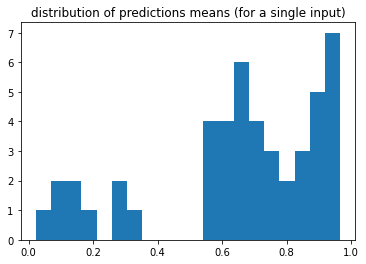

In [ ]:
plt.hist(means[0], bins=20)
plt.title('distribution of predictions means (for a single input)')
plt.show()

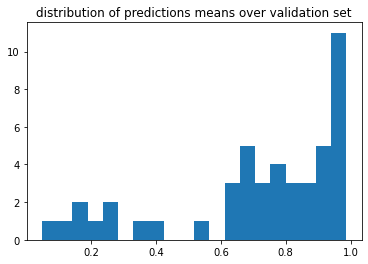

In [ ]:
plt.hist(np.mean(y_score, axis=0), bins=20)
plt.title('distribution of predictions means over validation set')
plt.show()

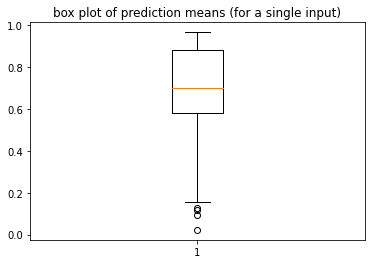

In [ ]:
plt.boxplot(means[0])
plt.title('box plot of prediction means (for a single input)')
plt.show()

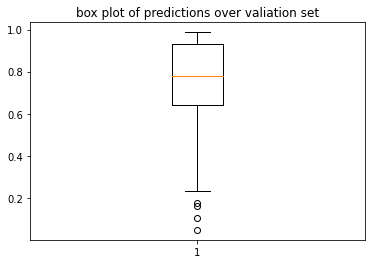

In [ ]:
plt.boxplot(np.mean(y_score, axis=0))
plt.title('box plot of predictions over valiation set')
plt.show()

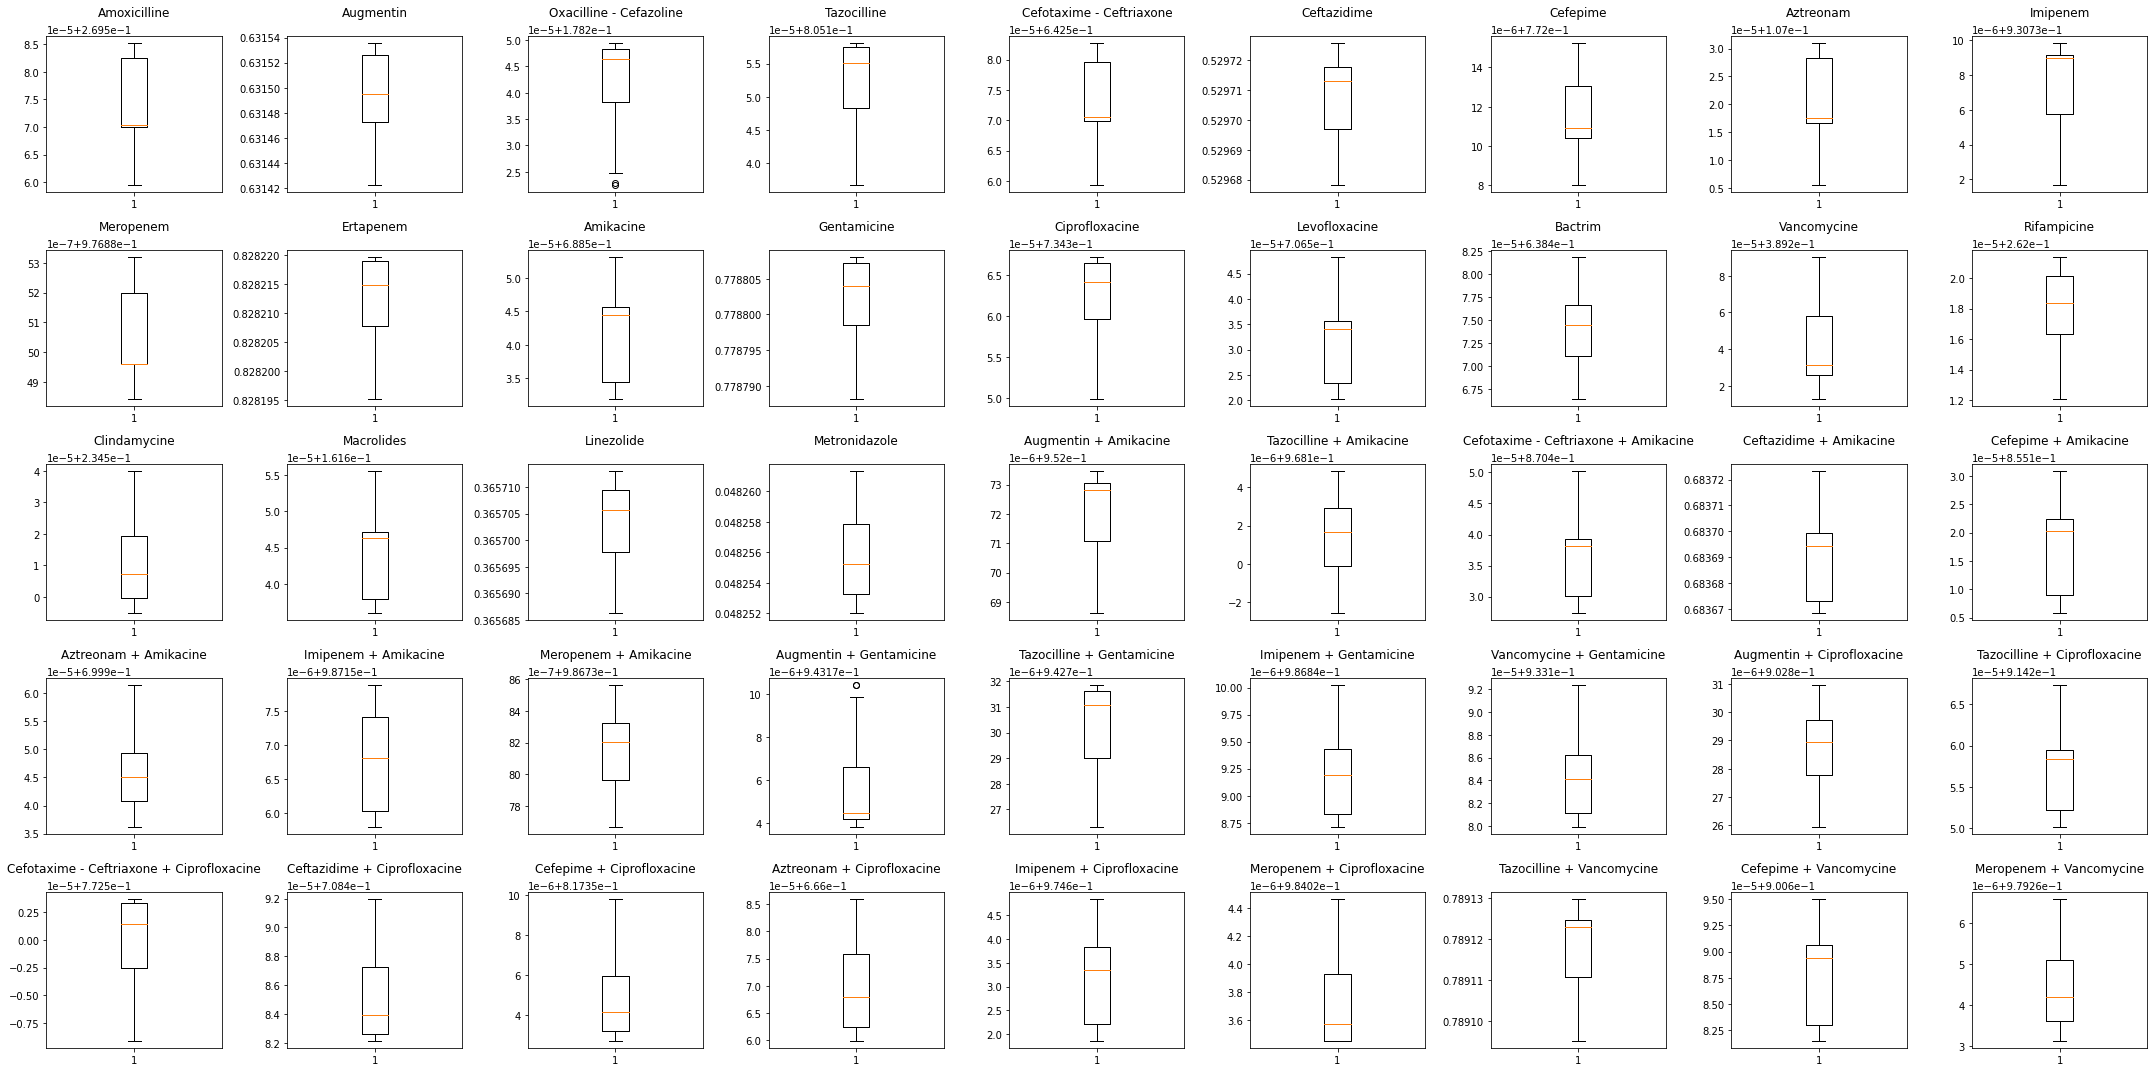

In [ ]:
fig, axs = plt.subplots(5, 9, figsize=(30,15))
plt.title('box plot for each antibiotic on the validation set')

for i, ax in enumerate(axs.ravel()):
    ax.boxplot(y_score[:,i])
    ax.set_title(antibiotiques[i], pad=20)

plt.tight_layout()

## Calibration curves / Reliability diagrams

In [ ]:
y_score = opt_model(X_val.values)

NameError: ignored

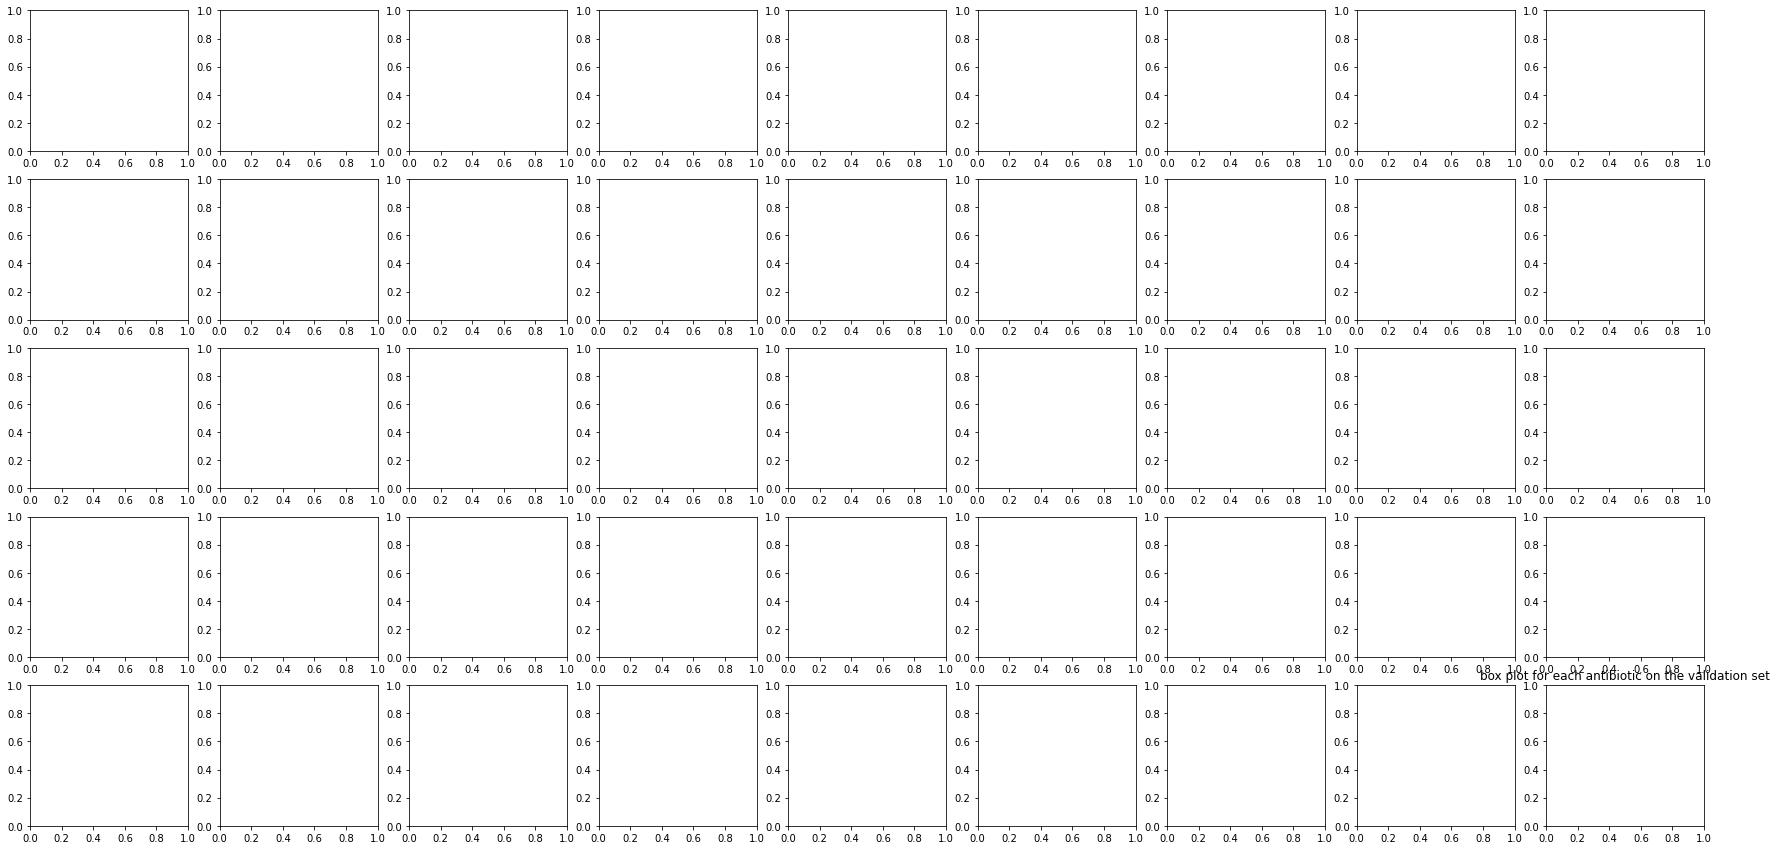

In [ ]:
fig, axs = plt.subplots(5, 9, figsize=(30,15))
plt.title('box plot for each antibiotic on the validation set')

for i, ax in enumerate(axs.ravel()):
    prob_true, prob_pred = calibration_curve(y_val.values[:,i], y_score[:,i])

    ax.plot(prob_pred, prob_true, 's-',label='mean calibrations')
    ax.plot([0,1], [0,1], '--', label='Perfectly calibrated')
    ax.set_title(y_val.columns[i], pad=15)
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positive')
    ax.legend()

plt.tight_layout()

# 7. Hybrid bayesian neural network 

In [132]:
def eval_aleatoric(model, X_val, y_val):
  preds_distributions = model(X_val.to_numpy())
  preds_means = preds_distributions.mean().numpy()
  preds_stdvs = preds_distributions.stddev().numpy()
  
  print('precision, recall, f1, support : ', precision_recall_fscore_support(y_val, preds_means.round(), average='weighted'))
  print('auc : ', roc_auc_score(y_val, preds_means))
  print('mean uncertainty : ', preds_stdvs.mean())
  
        
def run_eval_aleatoric(model, df_=df_D): 
  model.summary()
  print('******************************')
  print('Evaluation all stades : ')
  X_val, y_val = createDataSet(df_)
  all_stades = eval_aleatoric(model, X_val, y_val)

  eval_stades = [all_stades]
  print('\n\nEvaluation for each stade : ')
  # AUC for each stades 
  stades = [1, 2, 3, 4]
  for stade in stades:
    print('\n')
    print('---------------STADE {}---------------'.format(stade))
    X_val, y_val = getXY(df_, stade)
    
    eval_stades.append(eval_aleatoric(model, X_val, y_val))

  return eval_stades

In [80]:
nll = lambda y, yhat : -yhat.log_prob(y)

In [134]:
def create_aleatoric_model(units1=100, units2=100, units3=100, activation='elu'): 
  # input layer 
  inputs = keras.Input(shape=(X_train.shape[1],))
  x = BatchNormalization()(inputs)

  # hidden 
  x = Dense(500, activation='elu')(inputs)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  
  x = Dense(400, activation='elu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  
  x = Dense(100, activation='elu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)

  # output 
  outputs = Dense(47)(x)
  outputs = tfp.layers.IndependentBernoulli(n_antibiotiques)(outputs)

  # model compile
  model = keras.Model(inputs=inputs, outputs=outputs, name='HBNN')

  opt = keras.optimizers.Adam(learning_rate=0.0024)

  model.compile(loss=lambda y, yhat : -yhat.log_prob(y), 
                optimizer=opt, metrics=['Precision',
                                        'Recall',
                                        'AUC'
                                        ])
  model.summary()

  return model

In [135]:
aleatoric_bnn = create_aleatoric_model()
model = train_model(X_train, X_test, y_train, y_test, batch_size=32, model=aleatoric_bnn)

Model: "HBNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_61 (Dense)            (None, 500)               4000      
                                                                 
 batch_normalization_58 (Bat  (None, 500)              2000      
 chNormalization)                                                
                                                                 
 dropout_33 (Dropout)        (None, 500)               0         
                                                                 
 dense_62 (Dense)            (None, 400)               200400    
                                                                 
 batch_normalization_59 (Bat  (None, 400)              1600      
 chNormalization)                                             

Epoch 28/200
2639/2639 [==============================] - 15s 6ms/step - loss: 15.2713 - precision: 0.8517 - recall: 0.8513 - auc: 0.7697 - val_loss: 14.7223 - val_precision: 0.8581 - val_recall: 0.8590 - val_auc: 0.7784
Epoch 29/200
2639/2639 [==============================] - 15s 6ms/step - loss: 15.2627 - precision: 0.8515 - recall: 0.8516 - auc: 0.7696 - val_loss: 14.5967 - val_precision: 0.8564 - val_recall: 0.8702 - val_auc: 0.7799
Epoch 30/200
2639/2639 [==============================] - 15s 6ms/step - loss: 15.2188 - precision: 0.8520 - recall: 0.8523 - auc: 0.7705 - val_loss: 14.5931 - val_precision: 0.8578 - val_recall: 0.8578 - val_auc: 0.7776
Epoch 31/200
2639/2639 [==============================] - 14s 5ms/step - loss: 15.2350 - precision: 0.8521 - recall: 0.8519 - auc: 0.7704 - val_loss: 14.5019 - val_precision: 0.8590 - val_recall: 0.8590 - val_auc: 0.7795
Epoch 32/200
2639/2639 [==============================] - 14s 5ms/step - loss: 15.2184 - precision: 0.8520 - recall:

In [137]:
results = run_eval_aleatoric(aleatoric_bnn)

Model: "HBNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_61 (Dense)            (None, 500)               4000      
                                                                 
 batch_normalization_58 (Bat  (None, 500)              2000      
 chNormalization)                                                
                                                                 
 dropout_33 (Dropout)        (None, 500)               0         
                                                                 
 dense_62 (Dense)            (None, 400)               200400    
                                                                 
 batch_normalization_59 (Bat  (None, 400)              1600      
 chNormalization)                                             

In [84]:
def create_hbnn_transfer_model(base_model='saved/model_bs_64_e_100_n1_300_n2_100_n3_300_n4_100_a_leaky_relu_lr_0.0014.h5'): 
  # input layer 
  inputs = keras.Input(shape=(X_train.shape[1],))
  x = BatchNormalization()(inputs)

  model = load_model(base_model)
  # model.trainable = False

  for layer in model.layers:
    layer.trainable = False
    x = layer(x)

  # output 
  outputs = Dense(n_antibiotiques)(x)
  outputs = tfp.layers.IndependentBernoulli(n_antibiotiques)(outputs)
  # model compile
  model = keras.Model(inputs=inputs, outputs=outputs, name='transfer_aleatoric')

  opt = keras.optimizers.Adam(learning_rate=0.005)

  model.compile(loss=nll, 
                optimizer=opt, metrics=['Precision',
                                        'Recall',
                                        tf.keras.metrics.AUC(name='val_auc')])
  model.summary()

  return model

In [85]:
transfer_bnn = create_hbnn_transfer_model()
model = train_model(X_train, X_test, y_train, y_test, batch_size=32, model=transfer_bnn)

Model: "transfer_aleatoric"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 7)]               0         
                                                                 
 batch_normalization_29 (Bat  (None, 7)                28        
 chNormalization)                                                
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 batch_normalization_1 (Batc  (None, 7)                28        
 hNormalization)                                                 
                                                

Epoch 19/200
2639/2639 [==============================] - 7s 3ms/step - loss: 18.3606 - precision: 0.8195 - recall: 0.8194 - val_auc: 0.7196 - val_loss: 17.1142 - val_precision: 0.8287 - val_recall: 0.8337 - val_val_auc: 0.7346
Epoch 20/200
2639/2639 [==============================] - 7s 3ms/step - loss: 18.3630 - precision: 0.8192 - recall: 0.8194 - val_auc: 0.7193 - val_loss: 17.1798 - val_precision: 0.8252 - val_recall: 0.8431 - val_val_auc: 0.7328
Epoch 21/200
2639/2639 [==============================] - 7s 3ms/step - loss: 18.3112 - precision: 0.8198 - recall: 0.8197 - val_auc: 0.7200 - val_loss: 17.1611 - val_precision: 0.8263 - val_recall: 0.8194 - val_val_auc: 0.7276
Epoch 22/200
2639/2639 [==============================] - 7s 3ms/step - loss: 18.3525 - precision: 0.8195 - recall: 0.8193 - val_auc: 0.7195 - val_loss: 17.0915 - val_precision: 0.8244 - val_recall: 0.8395 - val_val_auc: 0.7308
Epoch 23/200
2639/2639 [==============================] - 7s 3ms/step - loss: 18.3361 - 

In [86]:
results = runEval(transfer_bnn)

Model: "transfer_aleatoric"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 7)]               0         
                                                                 
 batch_normalization_29 (Bat  (None, 7)                28        
 chNormalization)                                                
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 batch_normalization_1 (Batc  (None, 7)                28        
 hNormalization)                                                 
                                                

In [31]:
def multilabel_bce(y_true, y_pred): 
  bces = []
  for i in range(len(y_pred)):
    bce = tf.keras.losses.BinaryCrossentropy()
    bces.append(bce(y_true[:,i],  y_pred[:,i]).numpy())
  return np.mean(bces)


In [32]:
bce = tf.keras.losses.BinaryCrossentropy()

y_pred = np.array([[0.00001, 1., 0.5],
                  [.022, 1., 0.2],
                  [.0, .89, 0.70]])
          

y_true = np.round(y_pred)

print(bce(y_true, y_pred).numpy())
print(multilabel_bce(y_true, y_pred))

0.15686159095544797
0.15686159095544797


In [41]:
print(np.unique(y_train))

[0. 1.]


In [48]:
np.unique(y_train.values)

array([0., 1.])

In [59]:
weights = {}

for i in range(n_antibiotiques):
  weights[y_train.columns[i]]  = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train.values),
                                            y_train.values[:,i])
print(weights)


{'Amoxicilline': array([0.70711413, 1.70706394]), 'Augmentin': array([1.08128168, 0.93008409]), 'Oxacilline - Cefazoline': array([0.56361848, 4.42967596]), 'Tazocilline': array([2.09095383, 0.65713844]), 'Cefotaxime - Ceftriaxone': array([1.37394913, 0.78605784]), 'Ceftazidime': array([1.14265866, 0.889009  ]), 'Cefepime': array([1.8255048 , 0.68860739]), 'Aztreonam': array([0.60923592, 2.78862456]), 'Imipenem': array([4.29860057, 0.56581371]), 'Meropenem': array([7.37916064, 0.53634164]), 'Ertapenem': array([2.06889556, 0.65934776]), 'Amikacine': array([1.56858523, 0.7339542 ]), 'Gentamicine': array([1.80323231, 0.69183073]), 'Ciprofloxacine': array([1.39515158, 0.77928231]), 'Levofloxacine': array([1.80713071, 0.69125861]), 'Bactrim': array([1.43318905, 0.76789856]), 'Vancomycine': array([0.68992112, 1.81633598]), 'Rifampicine': array([0.61060018, 2.76039411]), 'Clindamycine': array([0.58203112, 3.54762402]), 'Macrolides': array([0.57421171, 3.86874052]), 'Linezolide': array([0.68691

In [60]:
def multilabel_bce(y_true, y_pred, class_weights): 
  y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
  out = -(y_true * K.log(y_pred)*class_weights[1] + (1.0 - y_true) * K.log(1.0 - y_pred)*class_weights[0])
  
  return K.mean(out, axis=-1)

In [38]:
def multilabel_var_ratio(predictions, average=False):
  # https://arxiv.org/pdf/1506.02142.pdf
  # 1 - (f_c^* / T)
  predictions = np.round(predictions).astype('int32')
  var_ratios = np.zeros(predictions.shape[1])
  for i in range(predictions.shape[1]):
    counts = np.bincount(predictions[:,i])
    var_ratios[i] = 1 - np.max(counts)/predictions.shape[0]

  if average:
    return var_ratios.mean()
  return var_ratios


predictions = np.array([[0.1, 0.1, 0.7],
                        [0.7, 0.2, 0.6],
                        [0.1, 0.1, 0.8]])


multilabel_var_ratio(predictions, average=True)

[[0 0 1]
 [1 0 1]
 [0 0 1]]


0.11111111111111112